# Federated Deep Learning on Vertically Partitioned SGCP Dataset

By Xiaochen Zhu

## Background

This notebook is an implementation of `vFedCCE` which is a private deep learning method using categorical cross entropy loss and gradient optimization to solve multi-category classfication problem in vertically partitioned datasets where labelled are only stored in one of the clients.

This particular implementation is an example when there are two categories but the same method applies to all classfication problem where categorical cross entropy loss function is the minimization goal.

## Set up environment

If you encounter error when running these `import`s, please restart runtime and try again.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.layers.experimental import preprocessing
import math
import uuid
import random
import zipfile

! pip -q install phe
from phe import paillier

# ! pip -q install clkhash
# from clkhash import clk, randomnames

## Data preperation

We need to load the data and vertically partition the dataset into two clients where each of them will have half the features and one of them will store the labels.

### Load and vertically partition the data

Just load the complete `csv` file into a dataframe.

In [2]:
# Download the zip file from the internet and unzip it
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
with zipfile.ZipFile('SouthGermanCredit.zip', 'r') as zip_ref:
    zip_ref.extractall('./SouthGermanCredit/')

--2021-07-05 15:09:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00573/SouthGermanCredit.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13130 (13K) [application/x-httpd-php]
Saving to: ‘SouthGermanCredit.zip.2’

SouthGermanCredit.z 100%[===================>]  12.82K  --.-KB/s    in 0s      

2021-07-05 15:09:44 (98.4 MB/s) - ‘SouthGermanCredit.zip.2’ saved [13130/13130]



In [3]:
original_df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
original_df.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


Give all entries a uuid and shuffle the two datasets so that later they can find matches based on that uuid.

In [4]:
id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
df_with_id = original_df.copy()
df_with_id['id'] = id
df_with_id = df_with_id.set_index('id')
client1_data = df_with_id[['moral','verw','beszeit','famges','wohnzeit','alter','wohn','beruf','telef','gastarb']]#.sample(frac=1)
client2_data = df_with_id[['laufkont','laufzeit','hoehe','sparkont','rate','buerge','verm','weitkred','bishkred','pers','kredit']]#.sample(frac=1)

In [5]:
# Client 1 has 10 features, no labels and the entries are shuffled
# client 2 has 11 features and labels and the entries are shuffled
print(client1_data)
print(client2_data)

                                      moral  verw  ...  telef  gastarb
id                                                 ...                
071e0cf3-5b79-4bdd-b0a9-e7f382498a43      4     2  ...      1        2
76b5663c-d7f3-4f7c-9783-e789cdc78898      4     0  ...      1        2
524c9f37-a5c0-43b2-9bd9-8cf613bbbd51      2     9  ...      1        2
20097113-7a9a-4422-a5cb-3216c4ad21b0      4     0  ...      1        1
426b3393-dc7d-4d49-99b3-241675055cff      4     0  ...      1        1
...                                     ...   ...  ...    ...      ...
4e740d83-ba3a-4baa-8d03-62974ebaceeb      2     3  ...      1        2
01ab8255-88a6-4397-aa66-d86e1afd9a5f      2     0  ...      1        2
ee1cc123-01b5-4292-940f-0d4a501fef6b      4     0  ...      2        2
a090a88e-e178-42bc-ad3f-00fa251845eb      2     3  ...      2        2
e8328204-e9f5-4bff-b0b3-c0cb06f55524      2     2  ...      1        2

[1000 rows x 10 columns]
                                      laufkont  lau

### Train/test split (non overlapping)



In [6]:
# # I want the test dataset to be balanced so that it makes sense for precision, recall, specificity
# # 100 common test entries
# common_test_true_index = np.random.choice(client2_data[client2_data['kredit']==1.0].index, 50)
# common_test_false_index = np.random.choice(client2_data[client2_data['kredit']==0.0].index, 50)
# common_test_index = np.union1d(common_test_true_index, common_test_false_index)

In [7]:
# # Other than the seperately picked common test entries, randomly add more entries
# client1_train, client1_test = train_test_split(client1_data.loc[~client1_data.index.isin(common_test_index)], test_size=0.05, random_state=42)
# client2_train, client2_test = train_test_split(client2_data.loc[~client2_data.index.isin(common_test_index)], test_size=0.05, random_state=420)
# client1_test = client1_data.loc[np.union1d(common_test_index, client1_test.index)]
# client2_test = client2_data.loc[np.union1d(common_test_index, client2_test.index)]

### [Do not run together with the previous section] Train/test split (overlapping)

In [8]:
client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=69)
client2_train = client2_data.loc[client1_train.index]
client2_test = client2_data.loc[client1_test.index]

### Train/test datasets info 

In [9]:
common_train_index = client1_train.index.intersection(client2_train.index)
common_test_index = client1_test.index.intersection(client2_test.index)

print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train),
        len(common_test_index),
        len(client1_test)))

There are 800 common entries (out of 800) in client 1 and client 2's training datasets,
and 200 common entries (out of 200) in their test datasets


## `vFedCCE`

### Parameters

In [10]:
batch_size = 32
learning_rate = 1e-3
epochs = 50

# Instantiate an optimizer.
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

### Helpers

In [11]:
def plot_loss(loss, accuracy):
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_accuracy(predictions, answers):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      if np.argmax(predictions[x]) == 1:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      if np.argmax(predictions[x]) == 0:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))


def convert_to_non_sparse(sparse):
  vector_list = np.zeros((len(sparse), 2))
  for x in range(len(sparse)):
    vector_list[x] = [1 - sparse[x], sparse[x]]
  return vector_list

### The `Client` class

Client 1 and client 2 both have half the features. Client 2 also stores the labels. If before each update of parameters, client 1 can send its partial prediction and other intermediate data to client 2, client 2 will be able to calculate the total loss and update the total model and give that updated model back to client 1.

Note that in this iteration of implementation, I do not plan to add implementation of entity resolution. Therefore, the examples with the same index on the two clients is ensured to point to the same end user.

In [12]:
class Client:

  def __init__(self, train_data, test_data, labelled):
    self.__trainX = train_data.copy()
    self.__testX = test_data.copy()
    self.labelled = labelled

    if (labelled):
      self.__trainY = self.__trainX.pop('kredit')
      self.__testY = self.__testX.pop('kredit')

    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(self.__trainX.loc[common_train_index]))

    self.model = tf.keras.Sequential([
      normalizer,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]
    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))
      return grads
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)

  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]

In [13]:
client1 = Client(client1_train, client1_test, False)
client2 = Client(client2_train, client2_test, True)

### Training loop

In [14]:
# train_index_batches = [common_train_index[i:i + batch_size] for i in range(0, len(common_train_index), batch_size)] 
common_train_index_list = common_train_index.to_list()

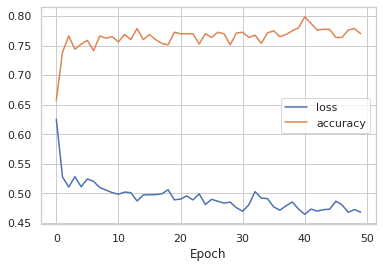

In [15]:
epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
  random.shuffle(common_train_index_list)
  train_index_batches = [common_train_index_list[i:i + batch_size] for i in range(0, len(common_train_index_list), batch_size)] 
  total_loss = 0.0
  # Iterate over the batches of the dataset.
  for step, batch_index in enumerate(train_index_batches):
    
    partial_grads = client1.next_batch(batch_index)
    client2.next_batch(batch_index)

    prob, loss_value = client2.loss_and_update(client1.cal_model())
    grad = client2.assemble_grad(partial_grads)
    client1.update_with(grad)
    
    total_loss = loss_value + total_loss
    train_acc_metric.update_state(client2.batch_answers(), prob)
  
  train_acc = train_acc_metric.result()
  train_acc_metric.reset_states()
  epoch_loss.append((total_loss)/(step + 1))
  epoch_acc.append(train_acc)

plot_loss(epoch_loss, epoch_acc)

### Make predictions on test data

In [16]:
predictions = (client1.predict(common_test_index) + client2.predict(common_test_index))/2
# predictions and answers are already aligned
plot_accuracy(predictions, client2.test_answers(common_test_index))
from sklearn.metrics import roc_auc_score
print("AUC: {}".format(roc_auc_score(client2.test_answers(common_test_index), predictions[:,1])))

Accuracy: 0.76
Precision: 0.7692307692307693
Recall: 0.935251798561151
F-Measure: 0.8441558441558442
AUC: 0.7637693124189172
